In [1]:
import time
import sys
import os
import dgl
import torch
from python.create_dgl_dataset import TelemacDataset
from hydra.utils import to_absolute_path


from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMGNSimilarity import MeshGraphNet

In [2]:
# def create_dummy_graph():
#     # Create a graph with 9 nodes and 15 edges (randomly chosen)
#     num_nodes = 400000
#     num_edges = 2000000
#     src = torch.randint(0, num_nodes, (num_edges,))
#     dst = torch.randint(0, num_nodes, (num_edges,))

#     graph = dgl.graph((src, dst))

#     # Add node data: 9 nodes with 3 features in 'x' and 'y'
#     graph.ndata['x'] = torch.randn(num_nodes, 9)  # 9 features per node
#     graph.ndata['y'] = torch.randn(num_nodes, 3)  # 3 additional features per node

#     # Add edge data: 15 edges with 3 features in 'x'
#     graph.edata['x'] = torch.randn(num_edges, 3)  # 3 features per edge

#     return graph

# # Create the dummy graph
# dummy_graph = create_dummy_graph()

In [ ]:
# data configs
data_dir = './workspace/datas/results_data_30min_35_70/Multimesh.bin'

dynamic_dir = ['./workspace/datas/results_data_30min_35_70/Group_3_peak_1000_Group_3_peak_1000_0_0-80.pkl','./workspace/datas/results_data_30min_35_70/Group_3_peak_1200_Group_3_peak_1200_0_0-80.pkl','./workspace/datas/results_data_30min_35_70/Group_3_peak_1400_Group_3_peak_1400_0_0-80.pkl','./workspace/datas/results_data_30min_35_70/Group_3_peak_1800_Group_3_peak_1800_0_0-80.pkl','./workspace/datas/results_data_30min_35_70/Group_3_peak_2000_Group_3_peak_2000_0_0-80.pkl','./workspace/datas/results_data_30min_35_70/Group_3_peak_2400_Group_3_peak_2400_0_0-80.pkl','./workspace/datas/results_data_30min_35_70/Group_3_peak_2600_Group_3_peak_2600_0_0-80.pkl','./workspace/datas/results_data_30min_35_70/Group_3_peak_2800_Group_3_peak_2800_0_0-80.pkl','./workspace/datas/results_data_30min_35_70/Group_3_peak_3000_Group_3_peak_3000_0_0-80.pkl','./workspace/datas/results_data_30min_35_70/Group_3_peak_3400_Group_3_peak_3400_0_0-80.pkl','./workspace/datas/results_data_30min_35_70/Group_3_peak_3600_Group_3_peak_3600_0_0-80.pkl',]

ckpt_path = './workspace/datas/test_similarity_x1'

In [78]:
data_dir= './workspace/datas/results_data_30min_35_70_maillagex2/Multimesh_2_32.bin'

dynamic_dir = ['./workspace/datas/results_data_30min_35_70_maillagex2/Group_3_peak_1000_Group_3_peak_1000_0_0-80_interpolated.pkl','./workspace/datas/results_data_30min_35_70_maillagex2/Group_3_peak_1200_Group_3_peak_1200_0_0-80_interpolated.pkl','./workspace/datas/results_data_30min_35_70_maillagex2/Group_3_peak_1400_Group_3_peak_1400_0_0-80_interpolated.pkl','./workspace/datas/results_data_30min_35_70_maillagex2/Group_3_peak_1800_Group_3_peak_1800_0_0-80_interpolated.pkl','./workspace/datas/results_data_30min_35_70_maillagex2/Group_3_peak_2000_Group_3_peak_2000_0_0-80_interpolated.pkl','./workspace/datas/results_data_30min_35_70_maillagex2/Group_3_peak_2400_Group_3_peak_2400_0_0-80_interpolated.pkl','./workspace/datas/results_data_30min_35_70_maillagex2/Group_3_peak_2600_Group_3_peak_2600_0_0-80_interpolated.pkl','./workspace/datas/results_data_30min_35_70_maillagex2/Group_3_peak_2800_Group_3_peak_2800_0_0-80_interpolated.pkl','./workspace/datas/results_data_30min_35_70_maillagex2/Group_3_peak_3000_Group_3_peak_3000_0_0-80_interpolated.pkl','./workspace/datas/results_data_30min_35_70_maillagex2/Group_3_peak_3400_Group_3_peak_3400_0_0-80_interpolated.pkl','./workspace/datas/results_data_30min_35_70_maillagex2/Group_3_peak_3600_Group_3_peak_3600_0_0-80_interpolated.pkl',]

ckpt_path = './workspace/datas/test_similarity_x2'

In [79]:
!ls workspace/

bin  datas  jupyter  launch.log  outputs  python  uts_Tet_full


In [80]:
dataset = TelemacDataset(
            name="telemac_test",
            data_dir=data_dir,
            dynamic_data_files=dynamic_dir,
            split="train",
            ckpt_path=ckpt_path,
            normalize=True,
            sequence_length=1,
            overlap=0
        )

Normalizing data...


In [81]:
model_test = MeshGraphNet(9,
            3,
            3,
            processor_size=10,
            hidden_dim_processor=64,
            hidden_dim_node_encoder=64,
            hidden_dim_edge_encoder=64,
            hidden_dim_node_decoder=64,
            do_concat_trick=True,
            num_processor_checkpoint_segments=0,)

In [82]:
def compute_dirichlet_energy(graph: dgl.DGLGraph) -> torch.Tensor:
    """
    Compute the Dirichlet energy for the graph's node features.
    
    The node features are stored in graph.ndata['x'].
    
    Parameters
    ----------
    graph : dgl.DGLGraph
        The graph containing node features `x` and edges.

    Returns
    -------
    torch.Tensor
        The computed Dirichlet energy (a scalar).
    """
    with graph.local_scope():
        # Node features
        node_features = graph.ndata['x']
        
        # Broadcast node features to edges
        graph.ndata['x'] = node_features
        graph.apply_edges(lambda edges: {
            'diff': edges.src['x'] - edges.dst['x']  # Compute differences between connected nodes
        })
        
        # Compute squared L2 norm for each edge
        graph.edata['squared_diff'] = torch.sum(graph.edata['diff'] ** 2, dim=-1)
        
        # Sum over all edges and normalize by the number of nodes
        dirichlet_energy = graph.edata['squared_diff'].sum() / graph.num_nodes()
    
    return dirichlet_energy



In [83]:
mean_dirichlet_energy = 0
for graphs in dataset : 
    graph = graphs[0]
    mean_dirichlet_energy += compute_dirichlet_energy(graph).item()
mean_dirichlet_energy = mean_dirichlet_energy/len(dataset)
print(mean_dirichlet_energy)

2752.1768523185483


In [5]:
# Create a dummy graph
dummy_graph = create_dummy_graph()

# Extract node and edge features
node_features = dummy_graph.ndata['x']
edge_features = dummy_graph.edata['x']

# Run the model
with torch.no_grad():
    output, dirichlet_energies = model_test(node_features, edge_features, dummy_graph)

print("Dirichlet Energies at each message passing step:", dirichlet_energies)


Dirichlet Energies at each message passing step: [724.5128784179688, 927.1813354492188, 1175.87109375, 1371.5762939453125, 1643.7657470703125, 1967.6458740234375, 2336.142333984375, 2579.775634765625, 2756.02783203125, 2920.44482421875]


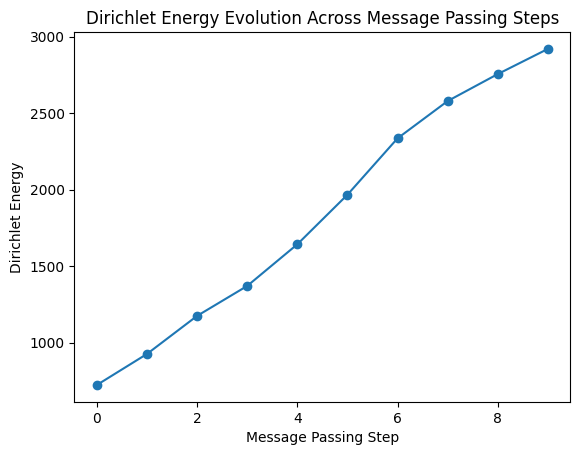

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(len(dirichlet_energies)), dirichlet_energies, marker='o')
plt.xlabel('Message Passing Step')
plt.ylabel('Dirichlet Energy')
plt.title('Dirichlet Energy Evolution Across Message Passing Steps')
plt.show()


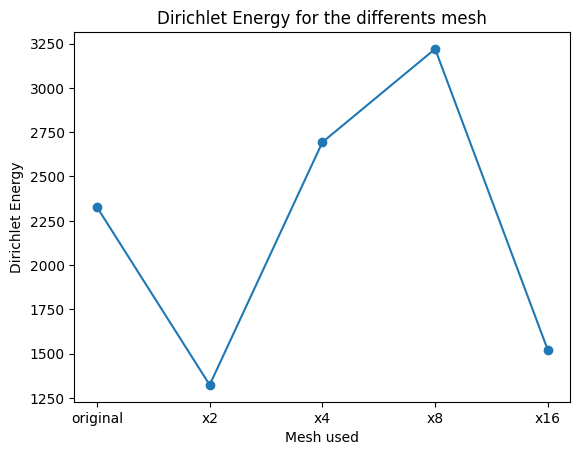

In [86]:
import matplotlib.pyplot as plt

simple = [2327.33,1323.69,2693.51,3220,1520]
plt.plot(['original','x2','x4','x8','x16'], simple, marker='o')
plt.xlabel('Mesh used')
plt.ylabel('Dirichlet Energy')
plt.title('Dirichlet Energy for the differents mesh')
plt.show()
